In [7]:
import numpy as np
import pandas as pd
import scipy.signal as sig
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tslearn.preprocessing import TimeSeriesResampler, TimeSeriesScalerMinMax
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation
from tslearn.metrics import lb_envelope, dtw

import src.packages.db.db_connect as db
import src.packages.utils.dataset as ds

%matplotlib notebook
%matplotlib inline

register_matplotlib_converters()

figsize=(9.8, 4)

ModuleNotFoundError: No module named 'src'

In [2]:
# Utils
def get_pattern(dataset, idx_start, idx_end):
    pattern = []

    for idx in range(idx_start, idx_end):

        pattern.append(dataset[idx])

    return pattern

In [3]:
ds.get_dataset_start(qtd_rows=2)

timestampdata    x_axis    y_axis    z_axis
0 2018-10-28 21:54:19.757409 -0.086143 -0.084458 -0.008396
1 2018-10-28 21:54:19.757459 -0.092604 -0.090753 -0.010494

In [4]:
# Dataset
axes = 'y_axis'
timestamp = 'timestampdata'

precision = 100

interval_sec = 60

dataset_raw, ts, te = ds.get_dataset_from_db(start_year=2018, start_month=10, start_day=28, start_hour=21, start_min=54, \
                                             start_sec=19, interval_sec=interval_sec)

# dataset_raw = ds.get_dataset_from_csv(r'C:\_Trindade\Git\time-series-csv\data\csv\split_1M\output_1.csv')

dataset_axes = dataset_raw[axes].values
dataset_timestamp = dataset_raw[timestamp]

In [5]:
# Series
default_series = pd.Series(dataset_axes)
series = pd.Series(dataset_axes, index=dataset_timestamp)

In [6]:
# Resample
resample_size = 2000 * precision
default_series = pd.Series(TimeSeriesResampler(sz=resample_size).fit_transform(default_series).ravel())
series = pd.Series(TimeSeriesResampler(sz=resample_size).fit_transform(series).ravel())

In [7]:
# Absolute
series = series.abs()

In [8]:
# Envelope
env_low, env_up = lb_envelope(series, radius=200)
# env_low, env_up = lb_envelope(env_up, radius=15)
series = pd.Series(env_up.ravel())

In [9]:
# Scale to Sax
n_paa_segments = 2000 * precision
n_sax_symbols = 20

sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)

min_scaler = min(sax.breakpoints_avg_middle_) 
max_scaler = max(sax.breakpoints_avg_middle_)

scaler = TimeSeriesScalerMinMax(min=min_scaler, max=max_scaler)
series = scaler.fit_transform(series)

sax_dataset_inv = sax.inverse_transform(sax.fit_transform(series))

sax_list = list(sax_dataset_inv.ravel())
idx_data = []

segment = True

for i in range(len(sax_list)):

    if sax_list[i] != sax.breakpoints_avg_middle_[0]:
        # idx_data.append(i)
        if not segment:
            idx_data.append(i)
        segment = True
    else:
        segment = False
        
print(idx_data[0])
print(idx_data[1])
print(idx_data[2])

AttributeError: 'SymbolicAggregateApproximation' object has no attribute 'breakpoints_avg_middle_'

In [ ]:


print('')
print(series.size)

figsize=(9.8, 6)

plt.figure(figsize=figsize)
plt.subplot(2, 1, 1)  # First, raw time series
plt.plot(default_series.ravel(), "b-")
plt.vlines(idx_data, min(default_series), max(default_series), 'red', 'dashed', lw=1)

plt.title("Raw time series")

plt.subplot(2, 1, 2)  # Then SAX
# plt.plot(series.ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), 'b-')
plt.hlines(sax.breakpoints_avg_, 0, resample_size, 'gray', 'dashed', alpha=0.4)
plt.vlines(idx_data, min_scaler, max_scaler, 'r', 'dashed', lw=1)

plt.title("Number of Layers - %d" % n_sax_symbols)

plt.tight_layout()


plt.show()

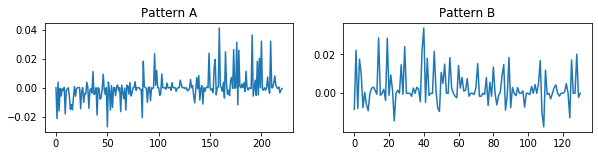

In [40]:
figsize=(9.8, 2)

# Patterns
data_window = []
default_patterns = []
patterns_A = []
patterns_B = []
dtw_A = []
dtw_B = []
dtw_AB = []

default_patterns.append(get_pattern(default_series, 126, 347))
default_patterns.append(get_pattern(default_series, 347, 478))

plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(default_patterns[0])
plt.title("Pattern A")

plt.subplot(1, 2, 2)
plt.plot(default_patterns[1])
plt.title("Pattern B")

plt.show()

In [41]:
    # Pattern compare
    
    for idx in range(len(idx_data) - 1):
    
        pattern_tmp = get_pattern(default_series, idx_data[idx], idx_data[idx + 1])


        similarity_A = dtw(default_patterns[0], pattern_tmp)
        similarity_B = dtw(default_patterns[1], pattern_tmp)

        if similarity_A < similarity_B:
            patterns_A.append(pattern_tmp)
            dtw_A.append(similarity_A)
            dtw_AB.append(similarity_A)
        else:
            patterns_B.append(pattern_tmp)
            dtw_B.append(similarity_B)
            dtw_AB.append(similarity_B)
     

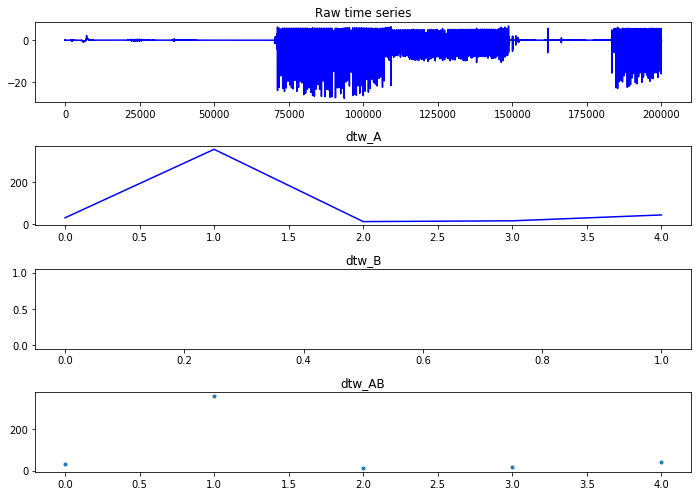

In [42]:
figsize=(9.8, 7)

plt.figure(figsize=figsize)
plt.subplot(4, 1, 1)  # First, raw time series
plt.plot(default_series.ravel(), "b-")
# plt.plot(patterns[0], "b-", 'red')
# plt.hlines(sax.breakpoints_avg_ , default_series.min(), default_series.max(), 'gray', 'dashed', alpha=0.4)
# plt.vlines(idx_data, min(default_series), max(default_series), 'red', 'dashed', lw=1)
plt.title("Raw time series")


plt.subplot(4, 1, 2)
plt.plot(dtw_A, "b-")
plt.title("dtw_A")

plt.subplot(4, 1, 3)
plt.plot(dtw_B, "b-")
plt.title("dtw_B")

plt.subplot(4, 1, 4)
plt.plot(dtw_AB, ".", lw=.5)
plt.title("dtw_AB")


plt.tight_layout()

# plt.draw()
# plt.pause(1e-17)

plt.show()